In [44]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [45]:
load_dotenv()

True

In [46]:
model  = ChatOpenAI(model="gpt-4o-mini")

In [47]:
class SentimentSchema(BaseModel):
  sentiment: Literal["positive", "negative"] = Field(description = "Sentiment of the review")
  
  

In [48]:
class DiagnosisSchema(BaseModel):
  issue_type : Literal["UX", "Performance", "Bugs", "Other"] = Field(description = "Type of issue in the review")
  tone : Literal["angry, frustrated, disappointed, calm"] = Field(description = "The emotional tone expressed by the user ")
  urgency : Literal["low", "medium", "high"] = Field(description = "How urgent or critial the issue appears to be")

In [49]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model_diagnosis = model.with_structured_output(DiagnosisSchema)

In [50]:
prompt = 'What is the sentiment of the fololowing review - The software too good'

response = structured_model.invoke(prompt).sentiment
response


'positive'

In [51]:
# State Define

class ReviewState(TypedDict):
  review: str
  sentiment: Literal["positive", "negative"]
  diagnosis: str

# class ReviewSchema(BaseModel):
#   review: str = Field(description = "The review text")
#   sentiment: Literal["positive", "negative"] = Field(description = "Sentiment of the review")
#   diagnosis: str = Field(description = "Diagnosis of the review")
  

In [52]:
def find_sentiment(state : ReviewState ):
  prompt = f'For the following review find out the sentiment \n {state["review"]} '
  sentiment = structured_model.invoke(prompt).sentiment
  return {"sentiment": sentiment}


def check_sentiment(state : ReviewState) -> Literal["positive_response", "run_diagonsis"]:
  
  sentiment = state["sentiment"]
  if sentiment == "positive":
    return 'positive_response'
  else:
    return "run_diagonsis"
  

def positive_response(state : ReviewState):
  
  prompt = f"""Write a warm thank-you message in response to this review: \n\n "{state["review"]}" Also, kindly ask the user to leave feedback on our website."""
  response = model.invoke(prompt).content
  return {"response" : response}



def run_diagonsis(state : ReviewState):
  
  prompt = f""" Diagnose this negative review :\n\n "{state["review"]}\n" 
  Return issue_type, tone, urgency.
  """
  response = structured_model_diagnosis.invoke(prompt)
  
  return {"diagnosis" : response.model_dump_json()}
  
  
  
def negative_response(state : ReviewState):
  
  diagnosis = state["diagnosis"]
  prompt = f"""You are a support assistant.
  The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}' and marked urgency as '{diagnosis['urgency']}'
  Write an empathetic and helpful resolution message .
  """
  response = model.invoke(prompt).content
  return {"response" : response}
  






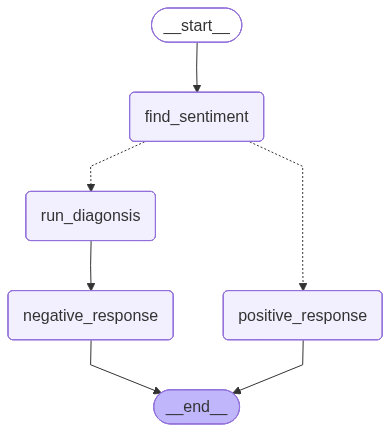

In [54]:
graph = StateGraph(ReviewState)


# Nodes 

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagonsis", run_diagonsis)
graph.add_node("negative_response", negative_response)

# Edges 



graph.add_edge(START, "find_sentiment")


graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagonsis", "negative_response")
graph.add_edge("negative_response", END)



# Run the workflow
workflow = graph.compile()


workflow






